In [1]:
import gym
import roboschool
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
plt.style.use('seaborn-white')
from baselines.common import set_global_seeds, tf_util as U
from baselines import bench
import gym, logging
import roboschool
from baselines import logger
from baselines.ppo1 import mlp_policy, pposgd_simple
from base_line_model.mlp import MlpPolicy_new
from base_line_model.PPO_agent import learning_agent

In [2]:
env = gym.make("RoboschoolHopper-v1")
env.seed(0)
np.random.seed(0)

seed = 1
logger.configure()
U.make_session(num_cpu=16).__enter__()
set_global_seeds(seed)

[2018-04-14 16:06:24,629] Making new env: RoboschoolHopper-v1


Logging to /tmp/openai-2018-04-14-16-06-24-636051


In [3]:
env2 = gym.make('RoboschoolHopper-v1')
env2 = bench.Monitor(env2, logger.get_dir(),allow_early_resets=True)
env2.seed(seed)
gym.logger.setLevel(logging.WARN)
class pargm(object):
    def __init__(self):
        self.timesteps_per_actorbatch = 25000#25000 # timesteps per actor per update
        self.clip_param = 0.2 
        self.entcoeff = 0.0 # clipping parameter epsilon, entropy coeff
        self.optim_epochs = 10 
        self.optim_stepsize = 3e-4
        self.optim_batchsize = 64# optimization hypers
        self.gamma = 0.99
        self.lam = 0.95 # advantage estimation
        self.max_timesteps=10e8#1e10 
        self.max_episodes=0 
        self.max_iters=0 
        self.max_seconds=0  # time constraint
        self.callback=None # you can do anything in the callback, since it takes locals(), globals()
        self.adam_epsilon=1e-5
        self.schedule='linear' # annealing for stepsize parameters (epsilon and adam)


def policy_fn(name, ob_space, ac_space):
        return MlpPolicy_new(name=name, ob_space=ob_space, ac_space=ac_space,
            hid_size=64, num_hid_layers=2)
    
parg = pargm()
agent = learning_agent('pi2', env2, policy_fn, parg)
agent.restore('hopper_mem')

[2018-04-14 16:06:24,671] Making new env: RoboschoolHopper-v1


INFO:tensorflow:Restoring parameters from hopper_mem/data


[2018-04-14 16:06:25,422] Restoring parameters from hopper_mem/data


In [4]:
repeat_times = 1000
observation_history = []
score_list = []
r2_list = []
for _ in range(repeat_times):
        observation = env.reset()
        done = False
        count_epi = 0
        score = 0
        s2 = 0
        while done == False:
            action = agent.action_ev(observation) # collect traj and agent current policy
            observation_, reward, done, info = env.step(action)
            observation = observation_
            r2 = reward
            observation_history.append(observation)
            score = score + reward
            # number of step before exit the simulation
            count_epi = count_epi + 1
            s2 = s2 + r2
        score_list.append(score)
        r2_list.append(s2)

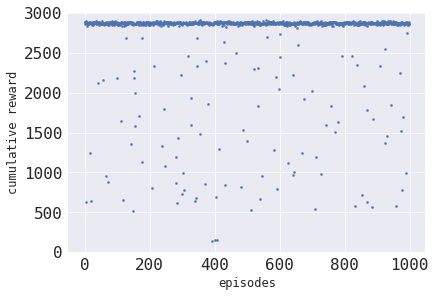

In [5]:
fon_size = 17
sns.set(context = "paper", font = "monospace", font_scale=2)
font_size = 12
x = list(range(0, 1000))
plt.scatter(x, score_list, s = 5)
plt.xlabel('episodes', fontsize = font_size)
plt.ylabel('cumulative reward',fontsize = font_size)
plt.ylim([0,3000])
plt.show()

# Sensor data statistics

In [6]:
sensor_array = np.array(observation_history)
sensor_array.shape

(950512, 15)

In [7]:
np.mean(sensor_array, 0)

array([-0.03884432,  0.        ,  1.        ,  0.66399175,  0.        ,
       -0.00946512,  0.        , -0.43612188,  0.84352392, -0.00248442,
        0.21607602, -0.00633407,  0.32618463,  0.0015047 ,  0.46557328], dtype=float32)

In [8]:
np.var(sensor_array, 0)

array([ 0.01839818,  0.        ,  0.        ,  0.39718643,  0.        ,
        0.19849548,  0.        ,  0.01089281,  0.00744506,  0.05182605,
        0.02982082,  0.08853318,  0.41047949,  0.42706633,  0.24892235], dtype=float32)

In [9]:
np.std(sensor_array, 0)

array([ 0.13563991,  0.        ,  0.        ,  0.63022727,  0.        ,
        0.4455283 ,  0.        ,  0.10436863,  0.08628476,  0.22765335,
        0.17268705,  0.29754525,  0.64068675,  0.65350312,  0.49892119], dtype=float32)

In [10]:
np.mean(r2_list)

2729.9675815115374

In [11]:
np.var(r2_list)

227520.91737052059